In [1]:
import numpy as np
import pandas as pd

pd.options.display.max_colwidth = 3000

from sklearn.model_selection import train_test_split, StratifiedKFold, ParameterGrid
from sklearn.metrics import  roc_curve, auc, roc_auc_score, confusion_matrix

from sklearn.feature_extraction.text import TfidfVectorizer
import xgboost as xgb
from xgboost import plot_importance

import tqdm
import pickle
from collections import defaultdict

import seaborn as sns
import matplotlib.pyplot as plt

read the data

In [2]:
df = pd.read_csv('./all_feats_for_analysis.csv')

In [66]:
df.head(1)

,doc,label,position,text,ticker,DATE_ENT_distance,MONEY_ENT_distance,NUMBER_ENT_distance,PERCENT_ENT_distance,PERSON_ENT_distance,...,URL_ENT_distance,has_!,has_?,has_emoji,has_special_emoji,relative_pos,word_count,word_max,word_mean,word_median
0,passed Hard Summer initiation covered two laye...,0,7,I passed the Hard Summer initiation by being c...,dirt,999,999,999,999,999,...,999,False,False,False,False,0.875,8,10,5.75,6.0


In [23]:
with open('./tickers.txt', 'r') as f:
    ticker_list = [t.strip() for t in f.readlines()]

## features

In [3]:
features_cols = ['DATE_ENT_distance','MONEY_ENT_distance', 'NUMBER_ENT_distance', 
             'PERCENT_ENT_distance', 'PERSON_ENT_distance', 'PICTURE_ENT_distance', 
             'URL_ENT_distance', 'has_!', 'has_?', 'has_emoji', 'has_special_emoji', 
             'relative_pos', 'word_count', 'word_max', 'word_mean', 'word_median']

col_for_tfidf = ['doc']

data_cols = features_cols + col_for_tfidf

# Train Test split

* TEST data is used only to evaluate final model
* TRAIN data is to split into 5-fold-CV

In [4]:
TRAIN, TEST, y_label_train, y_label_test = train_test_split(
                                                            df, 
                                                            df['label'], 
                                                            test_size=0.3, 
                                                            random_state=3, 
                                                            stratify=df['label']
                                                        )

TRAIN.reset_index(inplace=True, drop=True)
TEST.reset_index(inplace=True, drop=True)
y_label_train.reset_index(inplace=True, drop=True)
y_label_test.reset_index(inplace=True, drop=True)

# Cross Validation

In [5]:
skf = StratifiedKFold(n_splits=5, random_state=43)
cv_split = list(skf.split(TRAIN[data_cols], TRAIN['label']))

In [6]:
print('TRAIN.shape =', TRAIN.shape)
print('TEST.shape  =', TEST.shape)

TRAIN.shape = (171569, 21)
TEST.shape  = (73530, 21)


In [131]:
def tdidf_xgb_fit(X_train, y, xgb_kwargs, tfidf_kwargs):
    """fits tfidf and xgboost models
        input:
            * X_train 
            * y 
            * xgb_kwargs 
            * tfidf_kwargs    
        output:
            * tfidf - fitted tfidf model with tfidf_kwargs
            * model - fitted xgboost model with xgb_kwargs
    """
    
    X = X_train.copy(deep=True)
    
    # fit tfidf
    tfidf = TfidfVectorizer(**tfidf_kwargs)
    tfidf.fit(X['doc'].values)

    tfidf_feats = tfidf.transform(X['doc'].values).todense()
    
    X.drop(['doc'], axis=1, inplace=True)

    tfidf_feats_df = pd.DataFrame(
        tfidf_feats, 
        columns=['tf_idf_{}'.format(i) for i in range(tfidf_feats.shape[1])]
    )

    X = pd.concat([
        X.reset_index(drop=True), 
        tfidf_feats_df.reset_index(drop=True)], 
        axis=1
    )

    # for fixing type-bug
    for col in X:
        X.loc[:, col] = X[col].astype(float)

    # fit model    
    model = xgb.sklearn.XGBClassifier(**xgb_kwargs)
    model.fit(X, y)
    
    return tfidf, model


def tdidf_xgb_predict(X_val, tfidf, model):
    """ transforms doc into tfidf features and predicts the label
        input:
            * X_val
            * tfidf - fitted tfidf model
            * model - fitted xgboost model
        output:
            * p_val (probabilities)  
            * p_class (labels) 
    """
    X = X_val.copy(deep=True)
    
    tfidf_feats = tfidf.transform(X['doc'].astype(str).values).todense()
    X.drop(['doc'], axis=1, inplace=True)
    tfidf_feats_df = pd.DataFrame(
        tfidf_feats, 
        columns=['tf_idf_{}'.format(i) for i in range(tfidf_feats.shape[1])]
    )

    X = pd.concat([
        X.reset_index(drop=True), 
        tfidf_feats_df.reset_index(drop=True)], 
        axis=1
    )
    
    for col in X:
        X.loc[:, col] = X[col].astype(float)

    p_val = model.predict_proba(X)[:, 1]
    p_class = model.predict(X)

    return p_val, p_class


def get_cv_scores(TRAIN, cv_split, data_cols, xgb_kwargs, tfidf_kwargs):
    """ gets CV scores on 5 folds
        input:
            * TRAIN - all train data to be splitted, 
            * cv_split - StratifiedKFold splits, 
            * data_cols - feature columns, 
            * xgb_kwargs, 
            * tfidf_kwargs 
        output:
            * pvals - predictions for label 1, 
            * xgb_scores_df - dataframe with roc_auc scores on 5 folds
    """
    
    xgb_scores = []
    pvals = []

    for cv_idx_tr, cv_idx_val in tqdm.tqdm(cv_split, total=5):
        X_train = TRAIN.loc[cv_idx_tr, data_cols]
        y_train = TRAIN.loc[cv_idx_tr, 'label']

        X_val = TRAIN.loc[cv_idx_val, data_cols]
        y_val = TRAIN.loc[cv_idx_val, 'label']

        tfidf, model = tdidf_xgb_fit(X_train, y_train, xgb_kwargs, tfidf_kwargs)

        p_val, p_class = tdidf_xgb_predict(X_val, tfidf, model)

        roc_auc = roc_auc_score(y_val, p_val)
        xgb_scores.append({'roc_auc': roc_auc})

        pvals.append(p_val)

    xgb_scores_df = pd.DataFrame(xgb_scores)
    
    return pvals, xgb_scores_df

# Grid search

In [ ]:
parameters_grid = {
    'learning_rate': [0.03, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'colsample_bytree': [0.7, 1.0],
    'random_state': [43]
}

parameters_list = list(ParameterGrid(parameters_grid))

gridsearch_dfs = []

for parameters_kwargs in parameters_list:
    print('Checking {}'.format(parameters_kwargs))
    _, xgb_scores_df = get_cv_scores(
        TRAIN, cv_split, data_cols, parameters_kwargs, tfidf_kwargs
    )
    
    s = {'parameters': str(parameters_kwargs)}
    s.update({
            'roc_auc_{}'.format(i + 1): [xgb_scores_df['roc_auc'].values[i]] for i in range(5)
        })
    
    gridsearch_dfs.append(pd.DataFrame(s))

In [109]:
gridsearch_df = pd.concat(gridsearch_dfs, axis=0).reset_index(drop=True)

**save grid search results**

In [119]:
gridsearch_df.to_csv('./xgb_results_new.csv', index=None)

In [149]:
gridsearch_cv_results = pd.read_csv('./xgb_results_new.csv')

In [125]:
gridsearch_cv_results2 = pd.concat([
    gridsearch_cv_results,
    pd.DataFrame({
        'mean_score' : gridsearch_cv_results[['roc_auc_{}'.format(i + 1) for i in range(5)]].mean(axis=1)
    })
], axis=1)

In [150]:
gridsearch_cv_results2

,parameters,roc_auc_1,roc_auc_2,roc_auc_3,roc_auc_4,roc_auc_5,mean_score
0,"{'random_state': 43, 'max_depth': 7, 'colsample_bytree': 1.0, 'learning_rate': 0.3}",0.981752,0.980420,0.980730,0.981140,0.978854,0.980579
1,"{'random_state': 43, 'max_depth': 5, 'colsample_bytree': 1.0, 'learning_rate': 0.3}",0.977672,0.976306,0.976208,0.976229,0.973859,0.976055
2,"{'random_state': 43, 'max_depth': 3, 'colsample_bytree': 1.0, 'learning_rate': 0.3}",0.968060,0.967667,0.967744,0.968616,0.965498,0.967517
3,"{'random_state': 43, 'max_depth': 7, 'colsample_bytree': 1.0, 'learning_rate': 0.1}",0.970998,0.970195,0.969838,0.970487,0.967901,0.969884
4,"{'learning_rate': 0.03, 'random_state': 43, 'colsample_bytree': 0.7, 'max_depth': 3}",0.909614,0.906321,0.905985,0.907203,0.903386,0.906502
5,"{'learning_rate': 0.03, 'random_state': 43, 'colsample_bytree': 0.7, 'max_depth': 5}",0.937088,0.934954,0.935221,0.935177,0.932350,0.934958
6,"{'learning_rate': 0.03, 'random_state': 43, 'colsample_bytree': 0.7, 'max_depth': 7}",0.950508,0.949188,0.949846,0.950365,0.946303,0.949242
7,"{'learning_rate': 0.1, 'random_state': 43, 'colsample_bytree': 0.7, 'max_depth': 3}",0.946775,0.945844,0.946797,0.946577,0.943892,0.945977
8,"{'learning_rate': 0.1, 'random_state': 43, 'colsample_bytree': 0.7, 'max_depth': 5}",0.963027,0.961972,0.962111,0.962062,0.959385,0.961712
9,"{'learning_rate': 0.1, 'random_state': 43, 'colsample_bytree': 0.7, 'max_depth': 7}",0.971493,0.969972,0.970364,0.970310,0.968635,0.970155


# The final model choice

**The best parameters are - gridsearch_cv_results `.loc[12]` and `.loc[0]` - with mean score = `0.98`**

In [135]:
xgb_kwargs = {'learning_rate': 0.3, 'random_state': 43, 'colsample_bytree': 0.7, 'max_depth': 7, 'n_jobs': 4}
tfidf_kwargs = dict(max_features=200, stop_words=None)

**get CV scores with best parameters**

In [ ]:
pvals, xgb_scores_df = get_cv_scores(TRAIN, cv_split, data_cols, xgb_kwargs, tfidf_kwargs)

In [148]:
xgb_scores_df.T

,0,1,2,3,4
roc_auc,0.981632,0.980302,0.980189,0.980755,0.978752


# Model Evaluation

### Calculate mean and std scores on each ticker

In [35]:
def get_tickers_roc_aucs(df, i):
    """this function collects roc_auc score for each ticket separately
        input:
            * df - dataframe with label, ticker and prediction
            * i - fold number to give the prediction a unique name 
    """
    res = dict()
    for ticker in ticker_list:
        df1 = df[df['ticker'] == ticker]
        try:
            res[ticker + '_' + str(i)] = roc_auc_score(df1['label'], df1['pred_{}'.format(i)])
        except ValueError as exc: 
            print(ticker)
            print(exc)
    return res

**get roc_auc scores for each ticker on every fold**

In [36]:
folds_dict = dict()
i = 0
for cv_idx_tr, cv_idx_val in cv_split:
    fold_df = pd.DataFrame({
        'ticker': TRAIN.loc[cv_idx_val, 'ticker'],
        'label': TRAIN.loc[cv_idx_val, 'label'],
        'pred_{}'.format(i): pvals[i]
        }
    )
    folds_dict.update(get_tickers_roc_aucs(fold_df, i))
    i += 1

dirt
Only one class present in y_true. ROC AUC score is not defined in that case.


*only one ticker had no roc_auc on only one fold

**combine roc_auc scores together to one big dict**

In [38]:
tickers_roc_aucs = defaultdict(list)
for k, v in folds_dict.items():
    tickers_roc_aucs[k.split('_')[0]].append(v)

**count train examples for each ticker**

In [48]:
ticker_count_dict = dict()
for ticker in ticker_list:
    ticker_count_dict[ticker]  = TRAIN[(TRAIN['ticker'] == ticker) & (TRAIN['label'] == 1)].shape[0]

## sort tickers by number of examples on train

In [62]:
sorted_tickers = sorted(ticker_count_dict.items(), key=lambda x:x[1])

In [63]:
mean_metric, left_bound, right_bound = [], [], []

for ticker, _ in sorted_tickers:
    xs = tickers_roc_aucs[ticker]
    m = np.mean(xs)
    mean_metric.append(m)
    left_bound.append(m - np.std(xs) * 1.96)
    right_bound.append(m + np.std(xs) * 1.96)

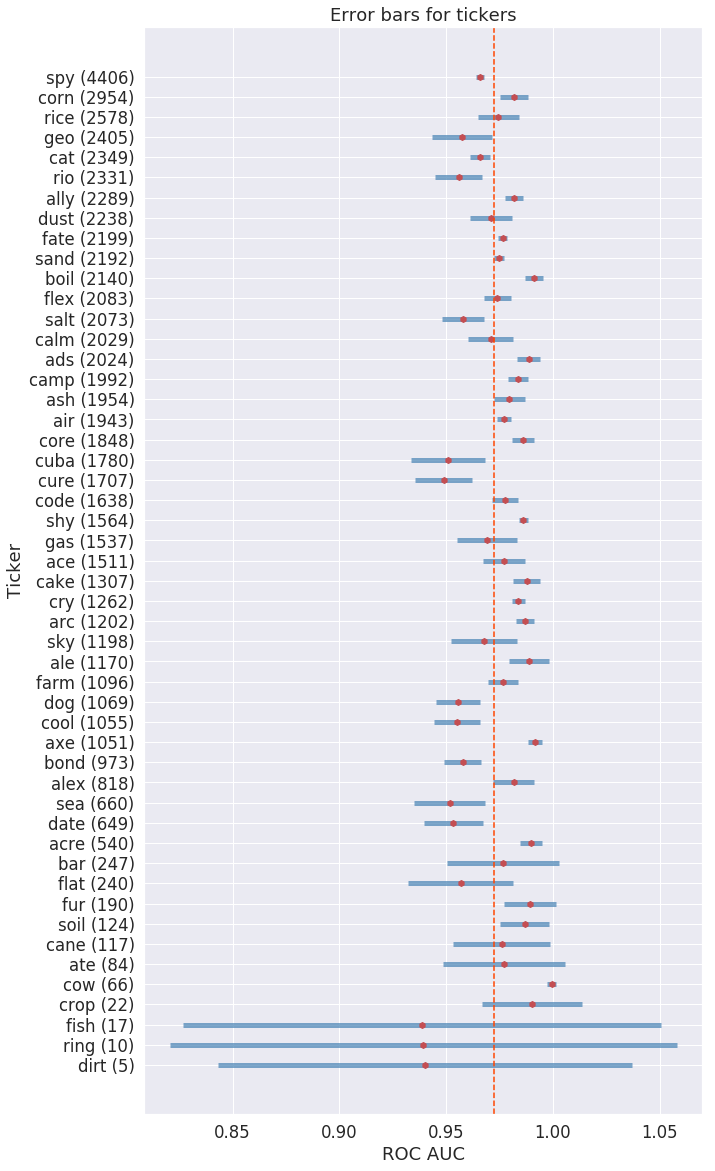

In [64]:
plt.figure(figsize=(10, 20))
ticker_list_w_count = ['{} ({})'.format(ticker, cnt) for ticker, cnt in sorted_tickers]

plt.hlines(y=ticker_list_w_count, xmin=left_bound, xmax=right_bound, linewidth=5, color='steelblue', alpha=0.7)
plt.plot(mean_metric, ticker_list_w_count, 'rh')
plt.axvline(x=np.mean(mean_metric), color='orangered', linestyle='--')
plt.xlabel('ROC AUC')
plt.ylabel('Ticker')
plt.title('Error bars for tickers')
plt.show()

# Model evaluation on TEST data

In [136]:
tfidf_fin, model_fin = tdidf_xgb_fit(TRAIN[data_cols], y_label_train, xgb_kwargs, tfidf_kwargs)

p_val_fin, p_class_fin = tdidf_xgb_predict(TEST[data_cols], tfidf_fin, model_fin)

roc_auc = roc_auc_score(y_label_test, p_val_fin)

## roc_auc

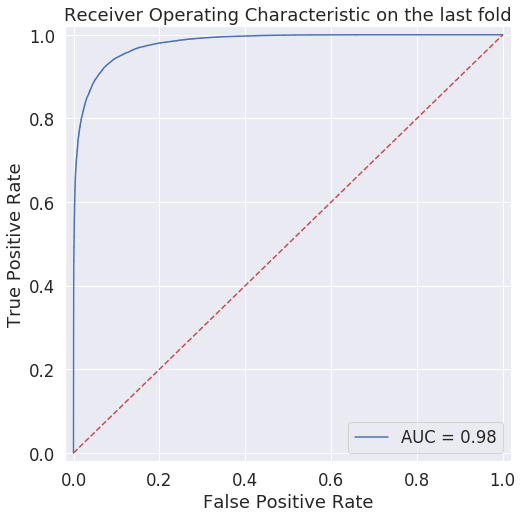

In [137]:
fpr, tpr, threshold = roc_curve(y_label_test, p_val_fin)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.title('Receiver Operating Characteristic on the last fold')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Feature Importance

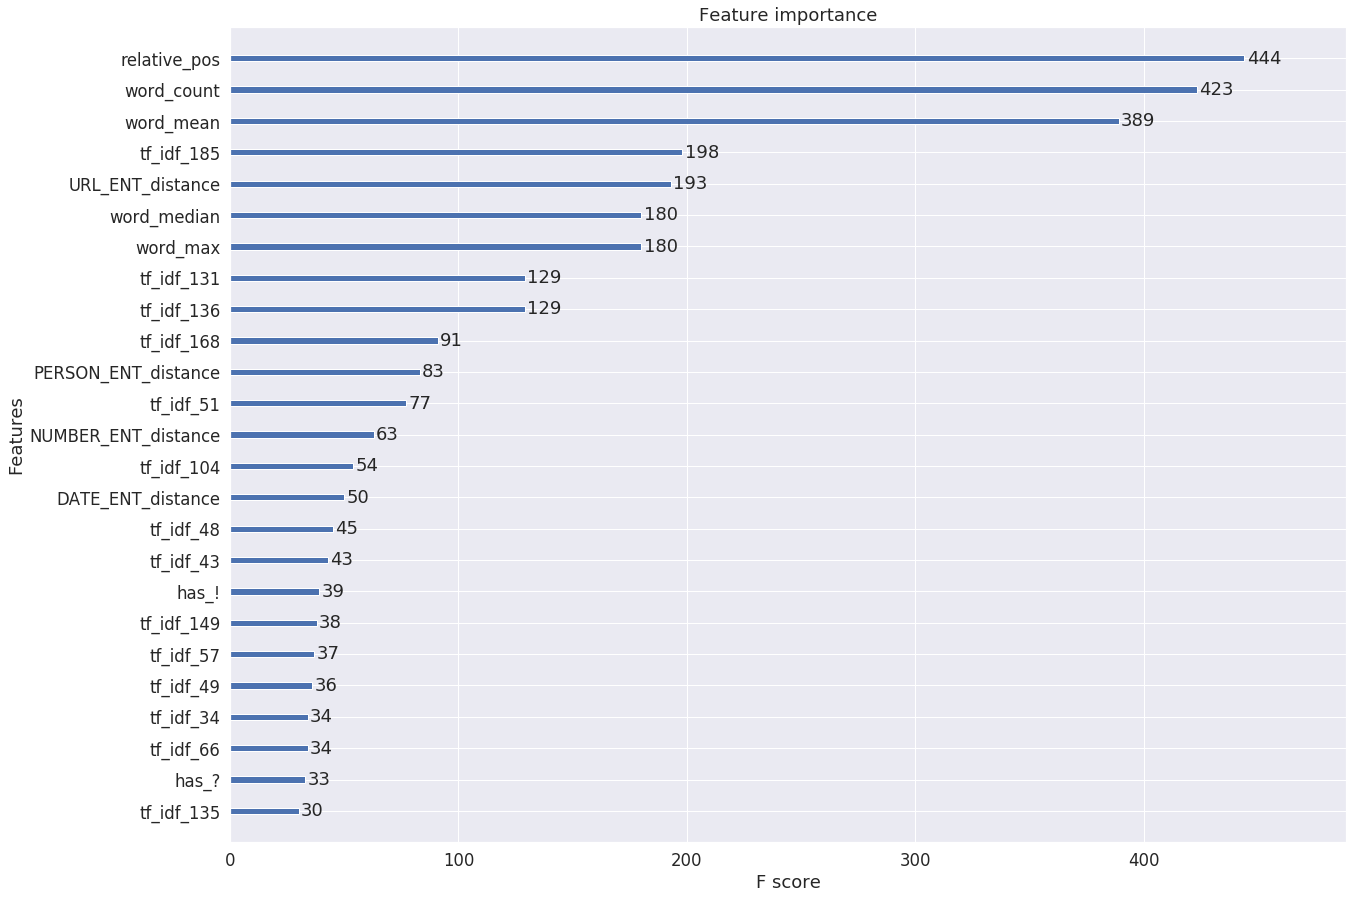

In [138]:
sns.set(font_scale=1.5) 
plt.figure(figsize=(20, 15))
plot_importance(model, ax=plt.gca(), max_num_features=25)
plt.show();

## Confusion matrix

In [139]:
m = confusion_matrix(y_label_test, p_class_fin)
m1 = m / m.sum(axis=0)

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(m1, annot=m, 
            xticklabels=['non-ticker', 'ticker'], 
            yticklabels=['non-ticker', 'ticker'],
            fmt='g'
           )
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()